In [1]:
#!/usr/bin/env python
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxx-------------------------OBSERVATION PLANNING----------------------xxxxxxxxxxxxxxxxxxxxxxxxx #
# xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx #


# ------------------------------------------------------------------------------------------------------------------- #
# Import Required Libraries
# ------------------------------------------------------------------------------------------------------------------- #
import math
import ephem
import easygui
import numpy as np
import astropy.units as u
from astropy.time import Time
from datetime import datetime
from matplotlib import pyplot as plt
from astropy.coordinates import Angle
from matplotlib.ticker import MultipleLocator
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Observatory & Telescope Details
# ------------------------------------------------------------------------------------------------------------------- #
OBS_NAME = 'Indian Astronomical Observatory, Hanle'
OBS_LONG = '78:57:51'
OBS_LAT = '32:46:46'
OBS_ALT = 4486
OBS_TIMEZONE = +5.5
telescope_horizon = 25
telescope_zenith = 85
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Functions For Error Handling
# ------------------------------------------------------------------------------------------------------------------- #

def remove_empty_values(python_list):
    """
    Args:
        python_list : Python list from which empty values are to be removed
    Returns:
        None
    """
    while True:
        try:
            python_list.remove('')
        except ValueError:
            break

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Defaults Used In Plotting Trajectories
# ------------------------------------------------------------------------------------------------------------------- #
time_offset = 0
date_obs = str(Time(Time.now(), format='iso', out_subfmt='date'))
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Manual Setup - GUI Code
# -------------------------------------------------------------------------------------------------------------------
box_msg = 'Enter Name, RA, DEC of objects to be plotted'
box_title = 'Details of objects'
field_names = ['Object 1', 'Object 2', 'Object 3', 'Object 4', 'Object 5']
field_values = ['SN2018gj 16:32:02.40 +78:12:41:13', 'SN2016gfy 07:26:43.67 85:45:51.70',
                'SN2018zd 06:08:03.18 +78:22:00.90', 'SN2018aoq 12:10:38.19 +39:23:47.00',
                'AT2018cow 16:16:00.22 22:04:16.83']

list_values = easygui.multenterbox(msg=box_msg, title=box_title, fields=field_names, values=field_values)

while True:
    try:
        list_values.remove('')
    except ValueError:
        break

while len(list_values) == 0:
    err_msg = box_msg + '\n\n Error: Aleast 1 Object required for plotting!!'
    list_values = easygui.multenterbox(msg=err_msg, title=box_title, fields=field_names, values=list_values)
    remove_empty_values(list_values)

choice_utc = easygui.boolbox(msg='Plot Trajectories W.r.t UTC?', title='UTC Or Local Time?', choices=['Yes', 'No'])
setup_manual = easygui.boolbox(msg='Manually Enter Date?', title='Manual Or Current Date?', choices=['Yes', 'No'])

if setup_manual:
    date_obs = easygui.enterbox(msg='Enter The Date Of Observation!', title='Date Of Observation',
                                    default=date_obs)

# choice_utc = True
# setup_manual = True

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Declaring Object 'telescope'
# ------------------------------------------------------------------------------------------------------------------- #
telescope = ephem.Observer()
telescope.pressure = 0
telescope.lon = OBS_LONG
telescope.lat = OBS_LAT
telescope.elevation = OBS_ALT
telescope.epoch = ephem.J2000
telescope.date = (Time(date_obs) + 1 * u.day - abs(OBS_TIMEZONE) * u.hour).utc.datetime
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Calculation Of Times Of Local Sunset & Sunrise
# ------------------------------------------------------------------------------------------------------------------- #
telescope.horizon = '-0:34'
time_sunset = telescope.previous_setting(ephem.Sun(), use_center=True)
time_sunrise = telescope.next_rising(ephem.Sun(), use_center=True)

datetime_sunset = Time(datetime.strptime(str(time_sunset).split('.')[0], '%Y/%m/%d %H:%M:%S'))
datetime_sunrise = Time(datetime.strptime(str(time_sunrise).split('.')[0], '%Y/%m/%d %H:%M:%S'))
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Calculation Of Times Of Nautical Twilight [Elevation Of Sun = -12 Degrees]
# ------------------------------------------------------------------------------------------------------------------- #
telescope.horizon = '-12'
time_twildusk = telescope.previous_setting(ephem.Sun(), use_center=True)
time_twildawn = telescope.next_rising(ephem.Sun(), use_center=True)

datetime_nightstart = Time(datetime.strptime(str(time_twildusk).split('.')[0], '%Y/%m/%d %H:%M:%S'))
datetime_nightend = Time(datetime.strptime(str(time_twildawn).split('.')[0], '%Y/%m/%d %H:%M:%S'))
datetime_midnight = datetime_nightstart.utc.datetime + \
                    (datetime_nightend.utc.datetime - datetime_nightstart.utc.datetime) / 2
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Determining Time Intervals
# ------------------------------------------------------------------------------------------------------------------- #
plot_duration = (datetime_sunrise.utc.datetime - datetime_sunset.utc.datetime).total_seconds() / 3600
utctime_intervals = datetime_sunset + np.linspace(time_offset, time_offset + plot_duration, 100) * u.hour
localtime_intervals = utctime_intervals + OBS_TIMEZONE * u.hour
moonsep_intervals = datetime_sunset + np.linspace(time_offset, time_offset + plot_duration, 8)[1:-1] * u.hour
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Colors Used In Plotting
# ------------------------------------------------------------------------------------------------------------------- #
colors = ['blue', 'green', 'red', 'saddlebrown', 'fuchsia', 'teal', 'black']
object_count = 0
# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Class 'ObjectToObs' For Declaring Objects To Be Observed
# ------------------------------------------------------------------------------------------------------------------- #

class ObjectToObs:
    def __init__(self, object_name, object_ra, object_dec, plot_ax):
        self.name = object_name
        self.object = ephem.FixedBody()
        self.object._epoch = ephem.J2000
        self.object._ra = object_ra
        self.object._dec = object_dec
        self.ax = plot_ax
        self.list_alt = []

    def get_altitude(self, time_obs):
        global telescope
        telescope.date = str(time_obs)
        self.object.compute(telescope)
        object_alt = Angle(str(self.object.alt) + ' degrees').degree
        return object_alt

    def get_moonsep(self, time_obs):
        global telescope
        telescope.date = str(time_obs)
        self.object.compute(telescope)
        moon_pos = ephem.Moon(str(time_obs))
        angle_ephem = ephem.separation(self.object, moon_pos)
        angle_sep = int(Angle(str(angle_ephem) + ' degrees').degree)
        return angle_sep

    def plot_objtrack(self, utc=True):
        for time_obs in list(utctime_intervals.value):
            self.list_alt.append(self.get_altitude(str(time_obs)))
        if utc:
            self.plot_in_utc()
        else:
            self.plot_in_local()

    def plot_in_utc(self):
        global object_count
        self.ax.plot(list(utctime_intervals.value), self.list_alt, label=self.name, color=colors[object_count],
                     linestyle='-', alpha=0.9)
        plot_intervals = [time for time in moonsep_intervals if int(self.get_altitude(str(time))) > 0]

        for time_obs in plot_intervals:
            self.ax.text(time_obs.value, self.get_altitude(str(time_obs)) + 0.5, self.get_moonsep(str(time_obs)),
                         fontsize=9, alpha=0.8)
        object_count += 1

    def plot_in_local(self):
        global object_count
        self.ax.plot(list(localtime_intervals.value), self.list_alt, label=self.name, color=colors[object_count],
                     linestyle='-', alpha=0.9)
        plot_intervals = [time for time in moonsep_intervals if int(self.get_altitude(str(time))) > 0]
        
        for time_obs in plot_intervals:
            local_time = time_obs + OBS_TIMEZONE * u.hour
            self.ax.text(local_time.value, self.get_altitude(str(time_obs)) + 0.5, self.get_moonsep(str(time_obs)),
                         fontsize=9, alpha=0.8)
        object_count += 1

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Setting Plot Parameters
# ------------------------------------------------------------------------------------------------------------------- #

def plot_obsplan(ax_obj, utc=True):
    """
    Sets plot parameters for plotting the trajectory of objects in sky.
    Args:
        ax_obj  : Axes object over which the observatory planning plot is displayed
        utc     : Boolean value to be determine whether UTC or Local Time is to be used for plotting
    Returns:
        None
    """
    def sign(value):
        return (value > 0) - (value < 0)

    # Observatory Details
    # ------------------------------------------------------------------------------------------------------------- #
    lat_deg = '%7.4f' % Angle(OBS_LAT + ' degrees').degree
    long_deg = '%7.4f' % Angle(OBS_LONG + ' degrees').degree

    text_ns = 'N'
    text_ew = 'E'

    if not sign(lat_deg):
        text_ns = 'S'
    if not sign(long_deg):
        text_ew = 'W'

    degree_sign = '$^\circ$'
    text_name = OBS_NAME + ' [+' + str(OBS_TIMEZONE) + 'h]\n'
    text_lat = 'Latitude : ' + lat_deg + degree_sign + text_ns
    text_long = ', Longitude : ' + long_deg + degree_sign + text_ew
    text_alt = ', Altitude : ' + str(OBS_ALT) + 'm'
    display_text = text_name + text_lat + text_long + text_alt + '\n'
    # ------------------------------------------------------------------------------------------------------------- #

    # Time
    # ------------------------------------------------------------------------------------------------------------- #
    sunset = datetime_sunset
    sunrise = datetime_sunrise
    night_start = datetime_nightstart
    night_end = datetime_nightend
    time_current = Time.now()
    time_print = datetime.strptime(str(time_current).split('.')[0], '%Y-%m-%d %H:%M:%S')

    if not utc:
        sunset += OBS_TIMEZONE * u.hour
        sunrise += OBS_TIMEZONE * u.hour
        night_start += OBS_TIMEZONE * u.hour
        night_end += OBS_TIMEZONE * u.hour
        time_current += OBS_TIMEZONE * u.hour
    # ------------------------------------------------------------------------------------------------------------- #

    # Set Plot Ticks
    # ------------------------------------------------------------------------------------------------------------- #
    ax_obj.xaxis.set_major_locator(HourLocator())
    ax_obj.yaxis.set_major_locator(MultipleLocator(10))
    ax_obj.yaxis.set_minor_locator(MultipleLocator(1))
    ax_obj.xaxis.set_minor_locator(MinuteLocator(byminute=range(0, 60, 5)))
    ax_obj.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    ax_obj.tick_params(axis='both', which='major', direction='in', width=1, length=8, labelsize=12)
    ax_obj.tick_params(axis='both', which='minor', direction='in', width=1, length=2, labelsize=12)
    # ------------------------------------------------------------------------------------------------------------- #

    # Plot Settings
    # ------------------------------------------------------------------------------------------------------------- #
    ax_obj.set_ylim(0, 90)
    ax_obj.set_xlim(sunset.value, sunrise.value)
    ax_obj.grid(True, linestyle='--')
    ax_obj.legend(shadow=True, loc=1)

    print (ax_obj.get_yticks())

    ax_obj.set_title(display_text, fontsize=16)
    ax_obj.set_ylabel('Elevation (In Degrees)', fontsize=16)
    if not utc:
        ax_obj.set_xlabel('\nLocal Time [In Hours]\nCurrent Time : ' + str(time_print) + ' UT', fontsize=16)
    else:
        ax_obj.set_xlabel('\nUniversal Time [In Hours]\nCurrent Time : ' + str(time_print) + ' UT', fontsize=16)
    # ------------------------------------------------------------------------------------------------------------- #

    # Print Text In The Plot
    # ------------------------------------------------------------------------------------------------------------- #
    ax_obj.text(sunset.value, 95, 'Sunset', rotation=+50, color='k', fontsize=10)
    ax_obj.text(sunrise.value,  95, 'Sunrise', rotation=+50, color='k', fontsize=10)
    ax_obj.text(night_start.value, 95, 'Twilight', rotation=+50, color='k', fontsize=10)
    ax_obj.text(night_end.value, 95, 'Twilight', rotation=+50, color='k', fontsize=10)
    ax_obj.text(night_start.value, 13, 'Nautical Dusk', rotation=-90, color='k', fontsize=10)
    ax_obj.text(night_end.value, 13, 'Nautical Dawn', rotation=-90, color='k', fontsize=10)

    print sunset
    print sunset.value
    print Time(sunset.value) + 5 * u.minute
    ax_obj.text((Time(sunset.value) + 5 * u.minute).utc.datetime, 1, 'Horizon', fontsize=10)
    ax_obj.text(ax_obj.get_xbound()[0], 88, 'Zenith', fontsize=10)
    ax_obj.text(ax_obj.get_xbound()[0], telescope_horizon + 1, 'Telescope Horizon', fontsize=10)
    ax_obj.text(ax_obj.get_xbound()[0], telescope_zenith - 2.5, 'Telescope Zenith', fontsize=10)

    moonphase_midnight = 'Moon Illumination = {0:.1f}%'.format(ephem.Moon(datetime_midnight).phase)
    ax_obj.text(x=datetime_midnight, y=91, s=moonphase_midnight, color='k', fontsize=10)

    print (ax_obj.get_yticks())

    if datetime_sunset.value < time_current.utc.datetime < datetime_sunrise.value:
        ax_obj.axvline(x=time_current.value, linestyle='--', color='k')
        ax_obj.text(time_current.value, 45, 'Current Time', rotation=-90, color='k', fontsize=10)
    # ------------------------------------------------------------------------------------------------------------- #

    # Fill Color In Sectors of Observation/Non-Observation
    # ------------------------------------------------------------------------------------------------------------- #
    ax_obj.axvline(x=night_start.value, linestyle='--', color='k')
    ax_obj.axvline(x=night_end.value, linestyle='--', color='k')

    ax_obj.set_facecolor('lightgray')
    ax_obj.fill_between(ax_obj.get_xbound(), telescope_horizon - 0.5, telescope_horizon + 0.5, facecolor='royalblue')
    ax_obj.fill_between(ax_obj.get_xbound(), telescope_zenith - 0.5, telescope_zenith + 0.5, facecolor='royalblue')
    ax_obj.fill_between(ax_obj.get_xbound(), telescope_horizon + 0.5, telescope_zenith - 0.5, facecolor='white')

    ax_obj.fill_between([sunset.value, night_start.value], telescope_horizon + 0.5,
                        telescope_zenith - 0.5, facecolor='orange')
    ax_obj.fill_between([night_end.value, sunrise.value], telescope_horizon + 0.5,
                        telescope_zenith - 0.5, facecolor='orange')
    # ------------------------------------------------------------------------------------------------------------- #

    # Plot The Y-Axis On The RHS With Airmass
    # ------------------------------------------------------------------------------------------------------------- #
    list_secz = []
    for altitude in ax_obj.get_yticks():
        if (1 / math.cos(math.radians(90 - altitude))) < 10:
            list_secz.append('%5.2f' % (1 / math.cos(math.radians(90 - altitude))))
        else:
            list_secz.append('NaN')

    ax_twin = ax_obj.twinx()
    ax_twin.set_ylim(0, 90)
    ax_twin.set_yticks(ax_obj.get_yticks())
    ax_twin.set_yticklabels(list_secz)
    ax_twin.set_ylabel('Airmass', fontsize=16)
    ax_twin.tick_params(axis='both', which='major', direction='in', length=10, width=1, labelsize=12)
    # ------------------------------------------------------------------------------------------------------------- #

    ax_obj.autoscale_view()
    fig.autofmt_xdate()
    plt.show()
    plt.close(fig)

# ------------------------------------------------------------------------------------------------------------------- #


# ------------------------------------------------------------------------------------------------------------------- #
# Plots The Trajectories Of Objects To Be Observed
# ------------------------------------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, value in enumerate(list_values):
    if len(value.split()) >= 3:
        ObjectToObs(object_name=value.split()[-3], object_ra=value.split()[-2],
                    object_dec=value.split()[-1], plot_ax=ax).plot_objtrack(utc=choice_utc)
    elif len(value.split()) == 2:
        ObjectToObs(object_name='Object ' + str(int(index) + 1), object_ra=value.split()[-2],
                    object_dec=value.split()[-1], plot_ax=ax).plot_objtrack(utc=choice_utc)
    else:
        print ("Error : Both RA & DEC For Object {} Need To Be Specified".format(str(int(index) + 1)))

plot_obsplan(ax_obj=ax, utc=choice_utc)
# ------------------------------------------------------------------------------------------------------------------- #



[-10.   0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
2018-08-02 13:40:40
2018-08-02 13:40:40
2018-08-02 13:45:40
[-10.   0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]


IndexError: list index out of range

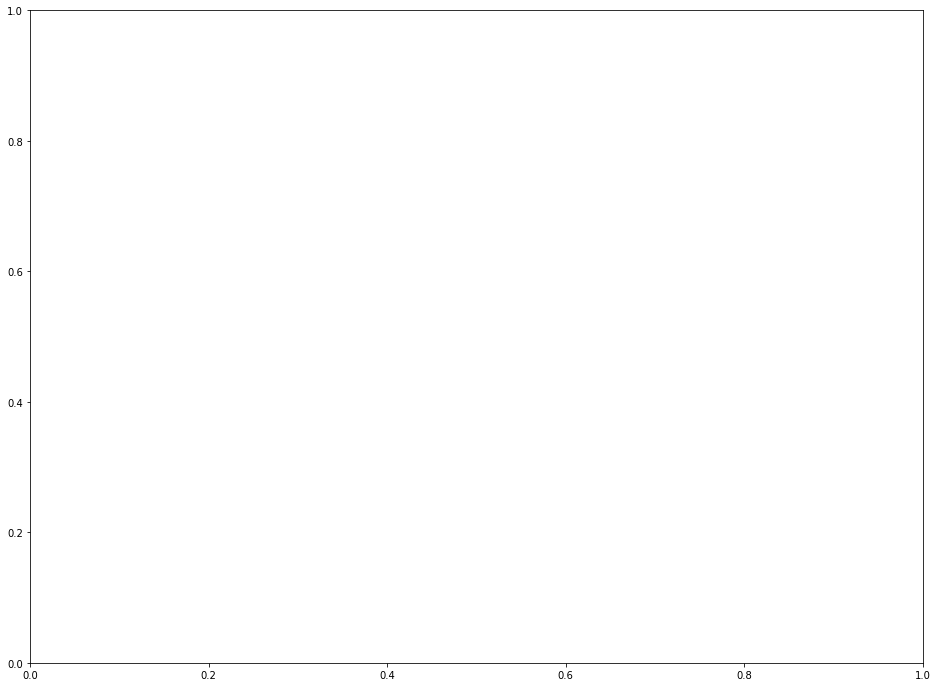